*Load packages and data:*

In [1]:
%run stdPackages.ipynb
read = {'variables': ['Fundamentals', 'LoadVariables', 'TransmissionLines', 'GeneratorsVariables'],
        'maps': ['LoadMaps','GeneratorsMaps'],
        'variable2D': ['HourlyVariation'],
        'scalars': ['Scalars']}
db = dbFromWB(os.path.join(d['data'],'E4.xlsx'), read)
readSets(db)

# Exercise 4: Technology Complementarity

*Auxiliary sets used to access g1:*

In [2]:
ids = db['id'][db['id'].str.startswith('g1')]
g   = pd.Index(['g1'],name='g')
hvts= db['hvt'][db['hvt'].str.startswith('g1')]
cE  = pd.Index(['c1'],name='c_E')
cH  = pd.Index(['c2'],name='c_H')

### Problem 1: Baseline scenario

We set up and solve the model using the simple call as in previous exercises:

In [3]:
m = mBasicPH.mSimple(db)
m.solve()

Solution status 0: Optimization terminated successfully.


There is naturally not "one correct" description of the baseline scenario. The following highlights some of the important parts of the baseline scenario.

*i) Generation capacity*

Let's start by looking at the generating capacities in the baseline (the ```rc_pd``` method subsets the symbol): In this baseline scenario, we can only use condensation plants and boiler heaters (we've left a very small generating capacity for other plants to be able to assess marginal economic value). These are the simple dispatchable plants. Note that the total installed capacity is 150 GJ for both electricity and heat producing plants (1.5 times the hourly average load).

In [4]:
rc_pd(m.db['GeneratingCap_E'], ids)

id
g1_BP_Coal       0.01
g1_BP_NatGas     0.01
g1_BP_BioMass    0.01
g1_CD_Coal         50
g1_CD_NatGas       50
g1_CD_Nuclear      50
g1_WS            0.01
g1_PV            0.01
Name: GeneratingCap_E, dtype: object

In [5]:
rc_pd(m.db['GeneratingCap_H'], ids)

id
g1_BH_BioMass      75
g1_BH_NatGas       75
g1_SH            0.01
g1_HP            0.01
Name: GeneratingCap_H, dtype: object

Let's define a subset of active plants (non-zero capacity):

In [6]:
active = m.db['GeneratingCap_E'][m.db['GeneratingCap_E']>0.01].index.union(
         m.db['GeneratingCap_H'][m.db['GeneratingCap_H']>0.01].index)
active = rc_pd(active, ids)

*ii) Prices/marginal system costs and marginal costs*

Electricity:
* In hours $h=1,4$ the marginal supply of electricity comes from the nuclear plant (```g1_CD_Nuclear```). 
* In $h=2$ the marginal supply of electricity comes from natural gas.
* In $h=3$ the final part of the load is shedded. The marginal willingness to pay is set at 50€ here.

Heat:
* In $h=2,3$ the marginal supply comes from natural gas (```g1_BH_NatGas```). 
* In $h=1,4$ the marginal supply of electricity comes from biomass (```g1_BH_BioMass```).

In [7]:
fig, axes = plt.subplots(1, 3, figsize = (20,4));
ax1, ax2, ax3 = plt.subplot(1, 3, 1), plt.subplot(1, 3, 2), plt.subplot(1, 3, 3);
m.db['marginalSystemCosts_E'].xs('g1').plot.bar(ax=ax1);
m.db['marginalSystemCosts_H'].xs('g1').plot.bar(ax=ax2);
rc_pd(m.db['mc'], active).sort_values().plot.bar(ax=ax3);

*iii) Emissions/fuel consumption*

Emissions start at roughly 40 tonnes of CO2 for the entire system. This comes from natural gas and coal (coal is more emission intensive, but consumption of natural gas is higher).

In [8]:
m.db['Emissions']

g   EmissionType
g1  CO2             40.184761
g2  CO2             40.184761
dtype: object

In [9]:
m.db['FuelConsumption'].xs('g1',level='g')

BFt
BioMass    128.698783
Coal       200.081633
NatGas     373.737851
Uranium    359.946429
dtype: object

*iv) Marginal economic value of technologies:*

* We note that the biomass plants are generally the ones with the lowest marginal economic value. If you go into more detail about the cost structure, you'll se that this is due to a combination of fuel costs and fixed operating and maintenance costs: Both are pretty high.
* Next, note that, in particular the back-pressure plant that relies on coal seem to worth investing in.

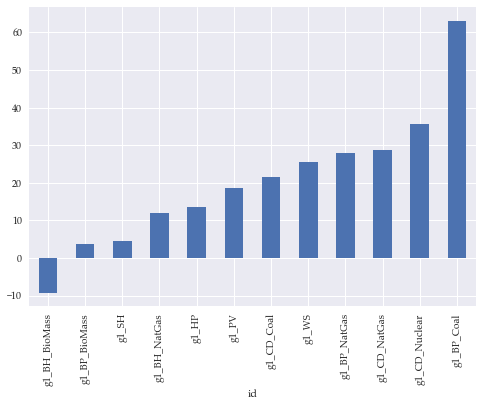

In [10]:
rc_pd(m.db['marginalEconomicValue'],ids).sort_values().plot.bar();

### Problem 2: Suggest a CHP plant strategy

*Note: There are, naturally, many different ways to solve this.*

Based on the results from problem 1, it looks like the back-pressure plant that relies on coal is particularly profitable; conversely, the biomass plant is quite costly to use. The least profitable electricity producing plant (that is currently active) looks to be the condensation plant that relies on coal (```g1_CD_Coal```).

We note that the plant ```g1_BP_Coal``` produces slightly more heat than electricity (electricity-to-heat ratio is less than 1):

In [11]:
db['E2H']

id
g1_BP_Coal           0.84
g1_BP_NatGas          1.3
g1_BP_BioMass        0.46
g2_BP_Coal           0.84
g2_BP_NatGas          1.3
g2_BP_BioMass        0.46
g1_HP           -0.285714
g2_HP           -0.285714
Name: E2H, dtype: object

If we entirely eliminate the coal plant ```g1_CD_Coal``` (capacity of 50 GJ/h), the corresponding heat capacity from the back-pressure plant will be $50/E2H$. So, we keep the generation capacity somewhat constant if we introduce the change:

In [12]:
db['GeneratingCap_E'].loc['g1_BP_Coal'] = 50
db['GeneratingCap_E'].loc['g1_CD_Coal'] = 0.01
db['GeneratingCap_H'].loc['g1_BH_BioMass'] = 75-50/0.84

Store a version of the solution before we re-solve, and then solve:

In [13]:
db_Before = db.copy()
m.solve()

Solution status 0: Optimization terminated successfully.


Now, compare the variables from earlier:

*i) Marginal System Costs:*

The condensation plant can drive down the cost of electricity, but not heat (there is still not enough heat generation to avoid the biomass plant):

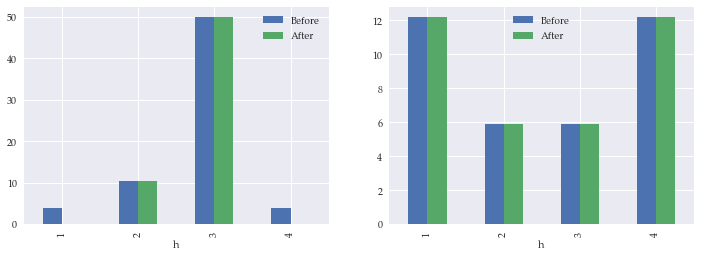

In [14]:
fig, axes = plt.subplots(1, 2, figsize = (12,4));
ax1, ax2 = plt.subplot(1, 2, 1), plt.subplot(1, 2, 2);
pd.DataFrame({'Before': db_Before['marginalSystemCosts_E'].xs('g1'), 'After': m.db['marginalSystemCosts_E'].xs('g1')}).plot.bar(ax=ax1);
pd.DataFrame({'Before': db_Before['marginalSystemCosts_H'].xs('g1'), 'After': m.db['marginalSystemCosts_H'].xs('g1')}).plot.bar(ax=ax2);

*ii) Emissions/fuel consumption*

Naturally, there is a change from biomass to coal. There is, however, also an overall drop in the total fuel that is used in power and heat generation; this is because the back-pressure plants usually feature significantly higher energy efficiency than the simpler condensation plants:

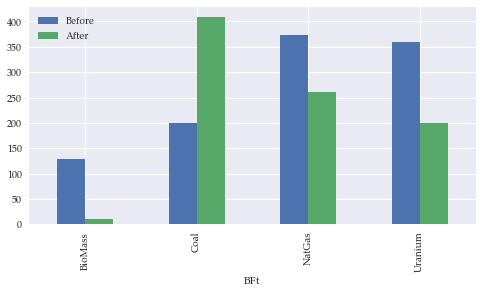

In [15]:
pd.DataFrame({'Before': db_Before['FuelConsumption'].xs('g1',level='g'), 'After': m.db['FuelConsumption'].xs('g1',level='g')}).plot.bar(figsize=(8,4));

Naturally, emissions increase with the use of coal:

In [16]:
pd.DataFrame({'Before': db_Before['Emissions'].xs('g1',level='g'), 'After': m.db['Emissions'].xs('g1',level='g')}).plot.bar(figsize=(8,4));

*iii) Marginal economic value of technologies:*

The changes are subtle. However, the value of the heat plants increase, whereas the value of intermittent technologies drop (WS,PV):

In [17]:
pd.DataFrame({'Before': rc_pd(db_Before['marginalEconomicValue'],ids),'After': rc_pd(m.db['marginalEconomicValue'],ids)}).sort_values(by='Before').plot.bar(figsize=(12,4));

### Problem 3: Marginal system costs with large shares of CHP

We update capacities and resolve:

In [18]:
newCaps = dbFromWB(os.path.join(d['data'],'E4.xlsx'), {'variables': ['UpdateCaps']})
db.symbols.update(**newCaps.symbols)
m.solve()

Solution status 0: Optimization terminated successfully.


Let's consider some of the same key variables as earlier:

*i) Marginal System Costs:*

* The marginal system costs of electricity has dropped overall. This is in part because of the higher overall generation capacity that means that an equilibrium can now be reached in $h=3$, but also because cheap intermittent renewables can cover the entire demand in hours $h=1,4$.
* The system costs for heat are lowered drastically in $h=2,3$, but increased in $h=1,4$.
    * In hours $h=1,4$, the electricity market draws on very cheap electricity from renewables. In this case, the marginal supply of heat comes from the backpressure plant that relies on biomass (```g1_BP_BioMass```). Because the electricity prices are low, the marginal costs of supplying heat is relatively high for CHP plants (the value stream from co-producing electricity is low).
    * In hour $h=2$ the production of renewable electricity is relatively low compared to the load. Thus, the marginal supply comes from the condensation plant that relies on natural gas (```g1_CD_NatGas```). With medium levels of electricity prices, the marginal supplier of heat is the heat pump. This results in relatively low prices.
    * In hour $h=3$ the demand for electricity is very high compared to the renewable generation. To satisfy the demand, all electricity generating plants are active. This in turn drives down the price on heat to zero. In the process of serving the electricity load, back-pressure plants co-produce more than enough heat to satisfy the heat demand.

In [19]:
fig, axes = plt.subplots(1, 2, figsize = (12,4));
ax1, ax2 = plt.subplot(1, 2, 1), plt.subplot(1, 2, 2);
pd.DataFrame({'Before': db_Before['marginalSystemCosts_E'].xs('g1'), 'After': m.db['marginalSystemCosts_E'].xs('g1')}).plot.bar(ax=ax1);
pd.DataFrame({'Before': db_Before['marginalSystemCosts_H'].xs('g1'), 'After': m.db['marginalSystemCosts_H'].xs('g1')}).plot.bar(ax=ax2);

*ii) Emissions/fuel consumption*

* Compared to before, the use of biomass and coal increases; this is due to the activation of back-pressure plants. 
* The drop in natural gas consumption comes from the generating capacity of the boiler heater going from 75 to 25. The back-pressure plant that relies on natural gas is only used in $h=3$ and thus does not offset this drop. 
* The drop in nuclear power comes from two sources: First, the renewable generation is cheaper thus replacing nuclear power in hours $h=1,4$. Second, the generating capacity for the nuclear plant is reduced from 50 to 25 and replaced by renewables/CHP plants.
* The net effect on emissions is only a slight drop: On one hand, we have a lot more renewables in the system. But, on the other hand, the back-pressure plants that rely on coal is used instead of the cleaner uranium and natural gas.

In [20]:
fig, axes = plt.subplots(1, 2, figsize = (12,4));
ax1, ax2 = plt.subplot(1, 2, 1), plt.subplot(1, 2, 2);
pd.DataFrame({'Before': db_Before['FuelConsumption'].xs('g1',level='g'), 'After': m.db['FuelConsumption'].xs('g1',level='g')}).plot.bar(ax=ax1);
pd.DataFrame({'Before': db_Before['Emissions'].xs('g1',level='g'), 'After': m.db['Emissions'].xs('g1',level='g')}).plot.bar(ax=ax2);

*iii) Marginal economic value of technologies:*

The new technology mix creates large differences to the marginal economic value of technologies. A couple of notable trends:
* The overall increase in generation capacity in electricity - in particular the cheap, renewable electricity - drives down the marginal economic value of *all* electricity producing plants, including back-pressure, condensation, and renewables. This is consistent with the generaL pattern:
    * Competing dispatchable technologies (```CD_NatGas, CD_BioMass, CD_Coal, BP_Coal, BP_BioMass, BP_NatGas```) are all **substitutes**: Introducing more of one of them decreases the value of the others. 
    * Intermittent renewables and dispatchables are imperfect substitutes: Introducing more wind/solar tends to drive down value of dispatchables. However, the substitution is less 1-to-1 than with other dispatchables, due to the intermittent nature of generation.
* The value of heat pumps increases because of the access to cheap, renewable electricity. The value of simple, natural gas boiler heaters increase as well, which is a simple *scale* effect in this scenario. As this is one of the cheaper means of producing heat, reducing the capacity from 75 to 25 leads to somewhat higher heat prices (in some hours); this is reflected in the higher value.

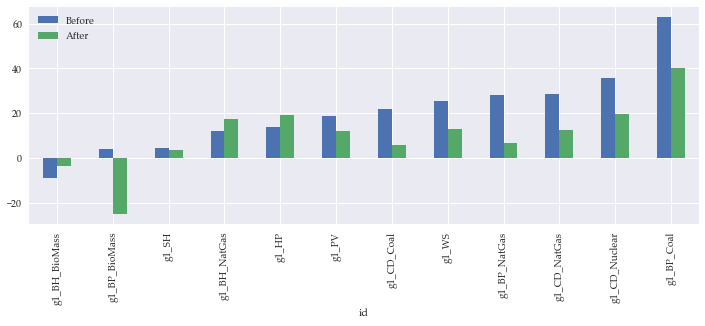

In [21]:
pd.DataFrame({'Before': rc_pd(db_Before['marginalEconomicValue'],ids),'After': rc_pd(m.db['marginalEconomicValue'],ids)}).sort_values(by='Before').plot.bar(figsize=(12,4));

### Problem 4: Renewables and heat pumps.

Create separate grids:

In [22]:
loop1 = pd.Index(range(11), name = 'l1')
loop2 = pd.Index(range(11), name = 'l2')
v0_ECap = pd.Series(50, index =  mBasicPH.getTechs_i(['PV','WS'],db))
vT_ECap = pd.Series(200, index = v0_ECap.index)
v0_HCap = pd.Series(25, index = mBasicPH.getTechs_i('HP',db))
vT_HCap = pd.Series(100, index = mBasicPH.getTechs_i('HP',db))
grid_ECap = addGrid(v0_ECap,vT_ECap,loop1,'GeneratingCap_E')
grid_HCap = addGrid(v0_HCap,vT_HCap,loop2,'GeneratingCap_H')

Collapse the two grids into two 1d grids with repeated levels:

In [23]:
df_E = lpCompiler.sortAll(addGrid(grid_ECap, grid_ECap, loop2, 'GeneratingCap_E').unstack('id'))
df_H = lpCompiler.sortAll(addGrid(grid_HCap, grid_HCap, loop1, 'GeneratingCap_H').unstack('id'))
df_E.index = df_E.index.to_flat_index().rename('loop')
df_H.index = df_H.index.to_flat_index().rename('loop')
grid_ECap_1d = df_E.stack().rename('GeneratingCap_E')
grid_HCap_1d = df_H.stack().rename('GeneratingCap_H')
loop = df_E.index

Solve and extract key variables:

In [24]:
extract = ['meanConsumerPrice_E','meanConsumerPrice_H','Generation_E','Generation_H','marginalEconomicValue','Emissions']
solution = m.loopSolveExtract(loop, [grid_ECap_1d, grid_HCap_1d], extract)

Now, let's go through a couple of results:

*i) The economic value of key technologies*

* The value of heat pump *increases* with the installed capacity of renewable energy and *decreases* with the amount of heat pump capacity. The effects are highly nonlinear.
* The value of photovoltaics depend mostly on the amount of installed capacity of renewable energy. But, with large capacity installed of intermittent renewables, the heat pump significantly increases the value.

In [25]:
v1, v2 = solution['marginalEconomicValue'].xs('g1_HP'), solution['marginalEconomicValue'].xs('g1_PV')
v1.index, v2.index =  pd.MultiIndex.from_tuples(v1.index.array).rename(['ECap','HCap']), pd.MultiIndex.from_tuples(v2.index.array).rename(['ECap','HCap'])
fig, axes = plt.subplots(1,2, subplot_kw={"projection": "3d"},figsize=(12,8));
ax = plt.subplot(1, 2, 1);
(X,Y),Z= np.meshgrid(loop1,loop2), v1.unstack('ECap').astype(float)
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.view_init(15,50);
ax.set_xlabel('Renew. E', labelpad = 10);
ax.set_ylabel('Heat pump', labelpad = 10);
ax.set_zlabel('Marginal Economic Value',labelpad=10);
ax.set_title('Heat Pump');
ax = plt.subplot(1, 2, 2);
(X,Y),Z= np.meshgrid(loop1,loop2), v2.unstack('ECap').astype(float)
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.view_init(15,50);
ax.set_xlabel('Renew. E', labelpad = 10);
ax.set_ylabel('Heat pump', labelpad = 10);
ax.set_zlabel('Marginal Economic Value',labelpad=10);
ax.set_title('Photovoltaics');
fig.tight_layout();

*ii) Marginal System Costs:*

* The average price on electricity decreases sharply with installed capacity of intermittent renewables. While it is not as easy to see in the following graph, the average price on electricity does increase with the level of installed heat pump capacity.
* The effects on the heat market are more pronounced here: Both heat pump capacity and renewable intermittent capacity affects the heat price.

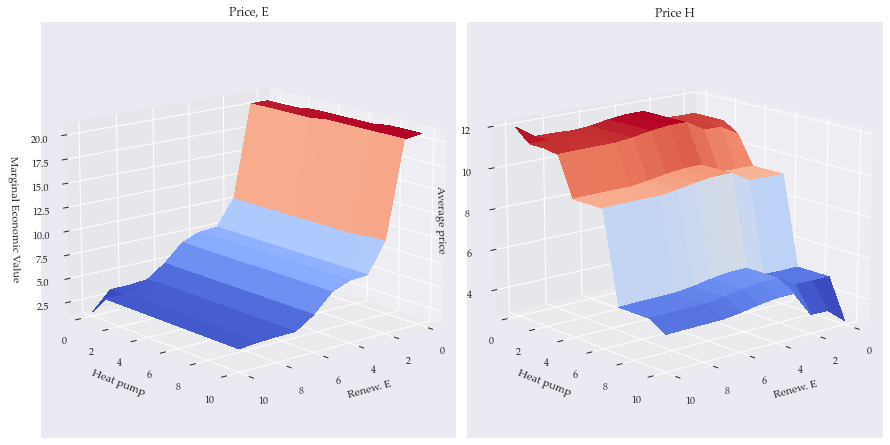

In [40]:
v1, v2 = solution['meanConsumerPrice_E'].xs('g1'), solution['meanConsumerPrice_H'].xs('g1')
v1.index, v2.index =  pd.MultiIndex.from_tuples(v1.index.array).rename(['ECap','HCap']), pd.MultiIndex.from_tuples(v2.index.array).rename(['ECap','HCap'])
fig, axes = plt.subplots(1,2, subplot_kw={"projection": "3d"},figsize=(12,8));
ax = plt.subplot(1, 2, 1);
(X,Y),Z= np.meshgrid(loop1,loop2), v1.unstack('ECap').astype(float)
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.view_init(15,50);
ax.set_xlabel('Renew. E', labelpad = 10);
ax.set_ylabel('Heat pump', labelpad = 10);
ax.set_zlabel('Marginal Economic Value',labelpad=10);
ax.set_title('Price, E');
ax = plt.subplot(1, 2, 2);
(X,Y),Z= np.meshgrid(loop1,loop2), v2.unstack('ECap').astype(float)
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.view_init(15,50);
ax.set_xlabel('Renew. E', labelpad = 10);
ax.set_ylabel('Heat pump', labelpad = 10);
ax.set_zlabel('Average price',labelpad=10);
ax.set_title('Price H');
fig.tight_layout();

*iii) Emissions*

Some of the most notable effects from increasing both types of capacity is on emissions. This is because the heat pump + intermittent renewable combination has direct and indirect effects on emissions:
* Direct effect: Heat pumps use - primarily - cheap renewable electricity to produce heat, and crowd out a mix of biomass, natural gas, and coal. Intermittent renewables similarly directly crowd out fossil fuels in electricity generation.
* Indirect effect: With a lot of intermittent renewables, installing more heat pumps allows us to better utilize the intermittent energy. This further crowds out fossil fuel consumption in the heat sector.

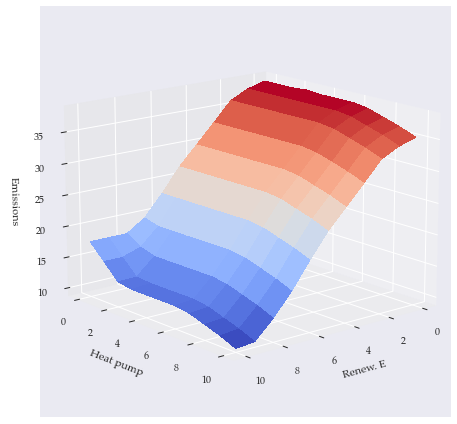

In [41]:
v = solution['Emissions'].xs('g1').xs('CO2')
v.index =  pd.MultiIndex.from_tuples(v.index.array).rename(['ECap','HCap'])
fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(6,6));
(X,Y),Z= np.meshgrid(loop1,loop2), v.unstack('ECap').astype(float)
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.view_init(15,50);
ax.set_xlabel('Renew. E', labelpad = 10);
ax.set_ylabel('Heat pump', labelpad = 10);
ax.set_zlabel('Emissions',labelpad=10);
fig.tight_layout();